In [1]:
import imageio as io
import numpy as np
from matplotlib import pyplot as plt

In [2]:
input_filename = "img_align_celeba/000005.jpg"
output_filename = ""
input_image = io.imread(input_filename)

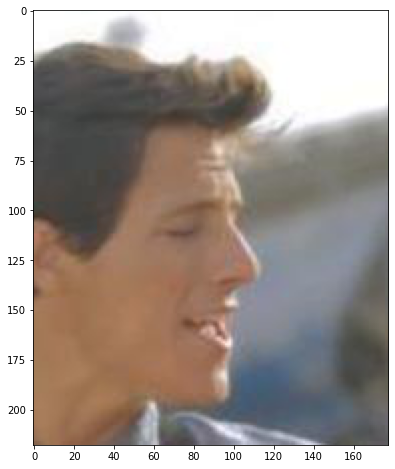

In [3]:
plt.subplots(figsize=(8,8))
plt.imshow(input_image)


In [4]:
lower = np.array([0, 48, 80], dtype=np.uint8)
upper = np.array([20, 255, 255], dtype=np.uint8)

In [5]:
def rgb_pixel2hsv(rgb_pixel: np.ndarray):
    r,g,b = rgb_pixel/255.0
    hsv_pixel = np.zeros((3,), dtype=np.float64)
    
    cmax = float(max(r, g, b))
    cmin = float(min(r, g, b))
    diff = cmax - cmin
    
    if (cmax == cmin):
        hsv_pixel[0] = 0
    elif (cmax == r):
        hsv_pixel[0] = ((60 * ((g - b) / diff) + 360) % 360)/360.0 * 255
    elif (cmax == g):
        hsv_pixel[0] = ((60 * ((b - r) / diff) + 120) % 360)/360.0 * 255
    elif (cmax == b):
        hsv_pixel[0] = ((60 * ((r - g) / diff) + 240) % 360)/360.0 * 255    
    
    if (cmax == 0):
        hsv_pixel[1] = 0
    else:
        hsv_pixel[1] = (diff / cmax) * 255
        
    hsv_pixel[2] = cmax * 255
        
    
    return hsv_pixel
    

In [6]:
def rgb2hsv(input_image: np.ndarray):
    n, m, _ = input_image.shape
    
    output_image = np.array([rgb_pixel2hsv(input_image[i][j]) for i in range(n) for j in range(m)],
                           dtype=np.float64).reshape(n,m,3)
    
    return output_image

In [7]:
hsv_image = rgb2hsv(input_image)

Text(0.5, 1.0, 'hue')

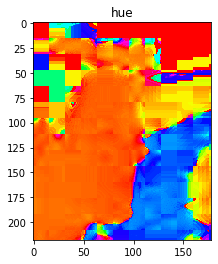

In [8]:
plt.imshow(hsv_image[:, :,0], cmap="hsv")
plt.title("hue")

In [9]:
def skin_mask(hsv_image: np.ndarray):
    n,m, _ = input_image.shape
    auxiliar = np.clip(np.multiply(np.where(hsv_image > lower,255, 0),np.where(hsv_image < upper,255,0)), 0,1)
    output = np.array([auxiliar[i][j][0]*auxiliar[i][j][1]*auxiliar[i][j][2] for i in range(n) for j in range(m)],
                      dtype=np.uint8).reshape(n,m)
    
    return output

In [10]:
mask_image = skin_mask(hsv_image)

In [11]:
def filter_median(src: np.ndarray, filter_size: int) -> np.ndarray:
    '''
    Returns the filtered src using the median filter with filter_size
    '''
    dst: np.ndarray = np.zeros(src.shape, dtype=np.uint8)
    src = np.pad(src, filter_size//2, mode="constant", constant_values=0)
    n,m = src.shape
    a:int = filter_size // 2

    for i in range(a, n - a):
        for j in range(a, m - a):
            sub_src = sorted(src[i - a : i + 1 + a, j - a : j + 1 + a].flatten())
            dst[i - a][j - a] = sub_src[(filter_size*filter_size)//2]
    
    return dst

In [12]:
mask_image = filter_median(mask_image, 9)

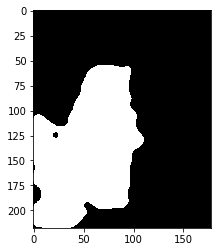

In [13]:
plt.imshow(mask_image, cmap="gray")

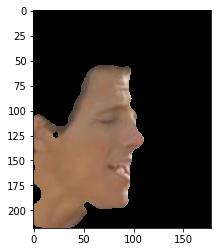

In [14]:
output_image = np.zeros(input_image.shape, dtype=np.uint8)
output_image[:, :, 0] = np.multiply(mask_image, input_image[:, :,0])
output_image[:, :, 1] = np.multiply(mask_image, input_image[:, :,1])
output_image[:, :, 2] = np.multiply(mask_image, input_image[:, :,2])
plt.imshow(output_image)